## ARISE-1.5 in the cloud - using kerchunck to improve access

In this notebook we use the kerchunk package to demonstrate a method of speeding up access to the ARISE-1.5 simulations hosted in the cloud on AWS. 

The motivation for using kerchunk is that these simulations, while avaiilable on the cloud, are not cloud optimized. 

By creating and then caching some reference files using kerchunk, we can massively speed up and simplify the process of working with the data. 

If you just want to work with the data, skip part 1. 

The code in this notebook is mostly copied from Lucas Sterzinger's tutorial here: 
https://medium.com/pangeo/fake-it-until-you-make-it-reading-goes-netcdf4-data-on-aws-s3-as-zarr-for-rapid-data-access-61e33f8fe685


We also use some code from the docs here:
https://fsspec.github.io/kerchunk/tutorial.html


In [22]:
# imports
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import datetime as dt
import logging
import fsspec
import ujson
from tqdm import tqdm
from glob import glob
fs = fsspec.filesystem('s3', anon=True)

### Part 1: generate the JSONs
This part is only needed the first time, or can be skipped entirely by downloading our output JSON file. For this test case using monthly data, it only takes around 30 seconds, but in general it can be slow, since the process involves opening and reading lots of .nc files. The time taken for this process is an order of magnitude estimate of the time saved by doing it, each time the pseduo-zarr dataset is used. 

In [23]:
# define a set of urls corresponding to some part of the ARISE-1.5 data set on AWS
# here we use globbing to get all 10 ensemble members of the monthly near-surface air temperature

urls = ['s3://' + f for f in fs.glob("s3://"+"ncar-cesm2-arise/ARISE-SAI-1.5/*/atm/proc/*/month_1/*TREFHT.*.nc")]
urls

['s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.

In [3]:
# start a dask client to open and process in parallel
import dask
from dask.distributed import Client
client = Client(n_workers=10)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33787,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:42201,Total threads: 1
Dashboard: http://127.0.0.1:46705/status,Memory: 1.60 GiB
Nanny: tcp://127.0.0.1:37759,


2024-11-27 16:54:02,037 - distributed.scheduler - WARNING - Worker failed to heartbeat for 596s; attempting restart: <WorkerState 'tcp://127.0.0.1:36513', name: 9, status: running, memory: 0, processing: 2>
2024-11-27 16:54:02,043 - distributed.scheduler - WARNING - Worker failed to heartbeat for 595s; attempting restart: <WorkerState 'tcp://127.0.0.1:37555', name: 6, status: running, memory: 0, processing: 2>
2024-11-27 16:54:02,044 - distributed.scheduler - WARNING - Worker failed to heartbeat for 596s; attempting restart: <WorkerState 'tcp://127.0.0.1:38947', name: 7, status: running, memory: 0, processing: 2>
2024-11-27 16:54:02,045 - distributed.scheduler - WARNING - Worker failed to heartbeat for 596s; attempting restart: <WorkerState 'tcp://127.0.0.1:39503', name: 8, status: running, memory: 0, processing: 2>
2024-11-27 16:54:02,045 - distributed.scheduler - WARNING - Worker failed to heartbeat for 596s; attempting restart: <WorkerState 'tcp://127.0.0.1:42201', name: 0, status: 

In [4]:
# generate 1 json file per .nc file, each json contains the metadata for that .nc
def gen_json(u):
    so = dict(
        mode="rb", anon=True, default_fill_cache=False,
        default_cache_type="none"
    )
    with fsspec.open(u, **so, expand=True) as inf:
        h5chunks = SingleHdf5ToZarr(inf, u, inline_threshold=300)
        with open(f"jsons/{u.split('/')[-1]}.json", 'wb') as outf:
           outf.write(ujson.dumps(h5chunks.translate()).encode())

In [5]:
# run over the file list:

import pathlib
pathlib.Path('./jsons/').mkdir(exist_ok=True)
dask.compute(*[dask.delayed(gen_json)(u) for u in urls])

(None, None, None, None, None, None, None, None, None, None)

In [18]:
"""
# now we can combine these into one
json_list = sorted(glob("./jsons/*.json"))
m_list = []
for js in tqdm(json_list):
    with open(js) as f:
        m_list.append(fsspec.get_mapper("reference://", 
            fo=ujson.load(f), remote_protocol="s3",
            remote_options={"anon": True}))
"""

'\n# now we can combine these into one\njson_list = sorted(glob("./jsons/*.json"))\nm_list = []\nfor js in tqdm(json_list):\n    with open(js) as f:\n        m_list.append(fsspec.get_mapper("reference://", \n            fo=ujson.load(f), remote_protocol="s3",\n            remote_options={"anon": True}))\n'

In [8]:
# we extract the ensemble member label from the filename - a bit of a hack
def fn_to_time(index, fs, var, fn):
    import re
    ex = re.compile(r'\.(\d{3})\.cam')
    return ex.search(fn).group(1)

In [9]:
## combine jsons into one mega json:
json_list = sorted(glob('./jsons/*.json'))

mzz = MultiZarrToZarr(json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map = {'Ensemble_member':fn_to_time},
    concat_dims=['Ensemble_member', 'time'],
    identical_dims = ['lat', 'lon']
)


mzz.translate('./combined_monthly_TREFHT.json')

{'version': 1,
 'refs': {'.zgroup': '{"zarr_format":2}',
  'Ensemble_member/.zarray': '{\n    "chunks": [\n        10\n    ],\n    "compressor": null,\n    "dtype": "<U3",\n    "fill_value": "",\n    "filters": null,\n    "order": "C",\n    "shape": [\n        10\n    ],\n    "zarr_format": 2\n}',
  'Ensemble_member/0': '0\x00\x00\x000\x00\x00\x001\x00\x00\x000\x00\x00\x000\x00\x00\x002\x00\x00\x000\x00\x00\x000\x00\x00\x003\x00\x00\x000\x00\x00\x000\x00\x00\x004\x00\x00\x000\x00\x00\x000\x00\x00\x005\x00\x00\x000\x00\x00\x000\x00\x00\x006\x00\x00\x000\x00\x00\x000\x00\x00\x007\x00\x00\x000\x00\x00\x000\x00\x00\x008\x00\x00\x000\x00\x00\x000\x00\x00\x009\x00\x00\x000\x00\x00\x001\x00\x00\x000\x00\x00\x00',
  'Ensemble_member/.zattrs': '{\n    "_ARRAY_DIMENSIONS": [\n        "Ensemble_member"\n    ]\n}',
  'time/.zarray': '{\n    "chunks": [\n        432\n    ],\n    "compressor": {\n        "checksum": false,\n        "id": "zstd",\n        "level": 0\n    },\n    "dtype": "<f8",\n    

## Part 2: using our new metadata jsons:

Execution time: 4.374522924423218 seconds


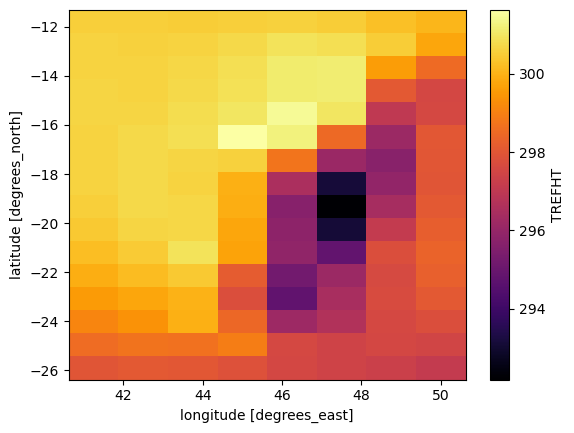

In [17]:
# lazy load open as a psuedo-zarr from the combined json:
# and plot
import time as timing
start_time = timing.time()

### START MAIN
fs = fsspec.filesystem(
    "reference", 
    fo="./combined_monthly_TREFHT.json", 
    remote_protocol="s3", 
    remote_options={"anon":True},
    skip_instance_cache=True
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine='zarr', backend_kwargs={'consolidated':False})

subset = ds.sel(lon=slice(41, 51),lat=slice(-26, -11), time=slice('2060', '2069')) 
subset.TREFHT.mean(['Ensemble_member', 'time']).plot(cmap='inferno')
### END MAIN

end_time = timing.time()
print(f"Execution time: {end_time - start_time} seconds")

### Part 3: repeat without kerchunk/zarr as a test of speed difference


Execution time: 27.431931257247925 seconds


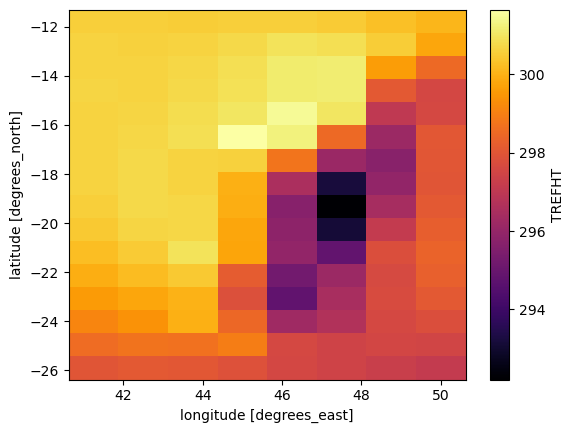

In [15]:
def get_trefht_data(scenario='ARISE'):
    da_list = []
    members = ['001', '002', '003', '004', '005', 
               '006', '007', '008', '009', '010']

    for member in members:

        #locs = {'ARISE':'ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}.cam.h0.TREFHT.203501-206912.nc'.format(m=member),
        #        'SSP245_1':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.201501-206412.nc'.format(m=member),
        #        'SSP245_2':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.206501-210012.nc'.format(m=member)}
        locs = {'ARISE':'ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}.cam.h0.TREFHT.*.nc'.format(m=member),
                'SSP245_1':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.*.nc'.format(m=member),
                'SSP245_2':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.*.nc'.format(m=member)}
        
        loc = locs[scenario]
        s3_path = "s3://" + loc
        # Open the dataset directly from the S3 URL using xarray
        with fsspec.open(s3_path, mode='rb', anon=True, expand=True) as file:
            da = xr.open_dataset(file, engine="h5netcdf")['TREFHT']
            da_list.append(da.load()) 
            # note that this takes a decent chunk of memory as we dont do anything clever with dask here            
    ds = xr.concat(da_list, dim='Ensemble_member').assign_coords({'Ensemble_member':members})       
    
    return ds

start_time = timing.time()

### START MAIN
ds2 = get_trefht_data(scenario='ARISE')
subset2 = ds2.sel(lon=slice(41, 51),lat=slice(-26, -11), time=slice('2060', '2069')) 
subset2.mean(['Ensemble_member', 'time']).plot(cmap='inferno')
### END MAIN

end_time = timing.time()
print(f"Execution time: {end_time - start_time} seconds")

## Part 3: repeat for a more meaty bit of processing to demonstrate the value

In [ ]:
# use daily data this time

urls = ['s3://' + f for f in fs.glob("s3://"+"ncar-cesm2-arise/ARISE-SAI-1.5/*/atm/proc/*/day_1/*TREFHT.*.nc")]

# generate 1 json file per .nc file, each json contains the metadata for that .nc
def gen_json(u):
    so = dict(
        mode="rb", anon=True, default_fill_cache=False,
        default_cache_type="none"
    )
    with fsspec.open(u, **so, expand=True) as inf:
        h5chunks = SingleHdf5ToZarr(inf, u, inline_threshold=300)
        with open(f"jsons/{u.split('/')[-1]}.json", 'wb') as outf:
           outf.write(ujson.dumps(h5chunks.translate()).encode())

# run over the file list:

import pathlib
pathlib.Path('./jsons_daily/').mkdir(exist_ok=True)
dask.compute(*[dask.delayed(gen_json)(u) for u in urls])

# we extract the ensemble member label from the filename - a bit of a hack
def fn_to_time(index, fs, var, fn):
    import re
    ex = re.compile(r'\.(\d{3})\.cam')
    return ex.search(fn).group(1)

## combine jsons into one mega json:
json_list = sorted(glob('./jsons_daily/*.json'))

mzz = MultiZarrToZarr(json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map = {'Ensemble_member':fn_to_time},
    concat_dims=['Ensemble_member', 'time'],
    identical_dims = ['lat', 'lon']
)


mzz.translate('./combined_day_TREFHT.json')

In [ ]:
## runs for a long time - > 10 mins. 